In [ ]:
# https://www.kaggle.com/code/maiieezz/cv-brain-mri-detection

# **Importing Modules**

In [5]:
import os
from os import listdir
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization, Rescaling, RandomFlip
from tensorflow.keras.layers import RandomRotation, RandomZoom, RandomContrast, RandomTranslation, RandomHeight, RandomWidth
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import tensorflow_datasets as tfds
import skimage.io as io
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import PIL
import cv2

In [6]:
data_dir='/kaggle/input/brainmri-data/brain_tumor_dataset'
data_no_dir = os.path.join(data_dir, 'no')
data_yes_dir = os.path.join(data_dir, 'yes')
os.makedirs('/kaggle/working/cropped_data', exist_ok=True)
os.makedirs('/kaggle/working/cropped_data/yes', exist_ok=True)
os.makedirs('/kaggle/working/cropped_data/no', exist_ok=True)
os.makedirs('/kaggle/working/aug_data', exist_ok=True)
os.makedirs('/kaggle/working/aug_data/yes', exist_ok=True)
os.makedirs('/kaggle/working/aug_data/no', exist_ok=True)

In [7]:
df = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 253 files belonging to 2 classes.


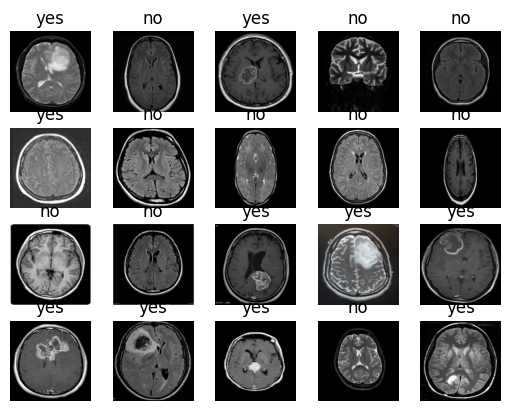

In [8]:
class_names = df.class_names
class_names
for images, labels in df.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
print('total no images :', len(os.listdir(data_no_dir)))
print('total yes images :', len(os.listdir(data_yes_dir)))

total no images : 98
total yes images : 155


# **Cropping Images**

In [10]:
def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts[0], key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    cropped_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return cropped_image

In [11]:
target_size = (224, 224)
cropped_yes_dir = '/kaggle/working/cropped_data/yes'
cropped_no_dir = '/kaggle/working/cropped_data/no'

cropped_yes_count = 0
cropped_no_count = 0
j=0
for images, labels in df:
    for i in range(len(images)):
        image_np = images[i].numpy().astype("uint8")
        cropped_image = crop_brain_contour(image_np, plot=False)
        resized_image = cv2.resize(cropped_image, target_size)
        label = labels[i].numpy()

        if label == 1:
            save_dir = cropped_yes_dir
            cropped_yes_count += 1
        else:
            save_dir = cropped_no_dir
            cropped_no_count += 1

        filename = f'image_{j}.jpg'
        j=j+1
        save_path = os.path.join(save_dir, filename)
        cv2.imwrite(save_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

In [12]:
cropped_data_dir = '/kaggle/working/cropped_data'
cropped_df = tf.keras.preprocessing.image_dataset_from_directory(cropped_data_dir)

Found 253 files belonging to 2 classes.


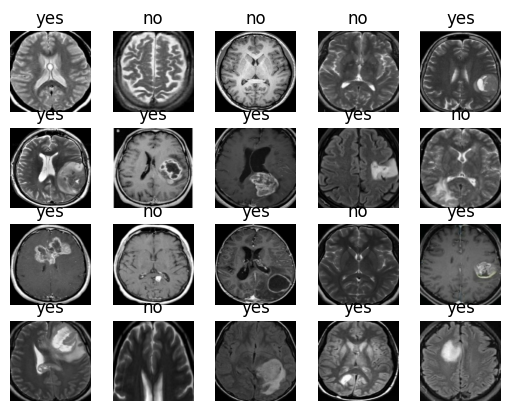

In [13]:
class_names = cropped_df.class_names
class_names
for images, labels in cropped_df.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# **Data Augmentation**

In [14]:
# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,  # Random rotation up to 30 degrees
    shear_range=0.2,  # Random shear
    horizontal_flip=True, 
    vertical_flip=True,  
    fill_mode='nearest',  # Filling mode for new pixels
    brightness_range=[0.8, 1.2]  # Random brightness adjustment
)

In [15]:
def augment_data(file_dir, n, save_to_dir):
    for filename in os.listdir(file_dir):
        # Load the image
        image_path = os.path.join(file_dir, filename)
        image = cv2.imread(image_path)
        if image is None:
            continue  # Skip if the image is not loaded properly
        
        image = np.expand_dims(image, axis=0)
        i = 1
        for batch in datagen.flow(image, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug_', save_format='jpg'):
            i += 1
            if i > n:
                break

In [16]:
augmented_yes_dir = '/kaggle/working/aug_data/yes'
augmented_no_dir = '/kaggle/working/aug_data/no'

# Apply augmentation to 'cropped_yes' and 'cropped_no'
augment_data(cropped_yes_dir,  6, augmented_yes_dir)
augment_data(cropped_no_dir, 10, augmented_no_dir)

In [17]:
aug_data_dir = '/kaggle/working/aug_data'
aug_df = tf.keras.preprocessing.image_dataset_from_directory(aug_data_dir)

Found 1827 files belonging to 2 classes.


In [18]:
print('total no images :', len(os.listdir(augmented_no_dir)))
print('total yes images :', len(os.listdir(augmented_yes_dir)))

total no images : 940
total yes images : 887


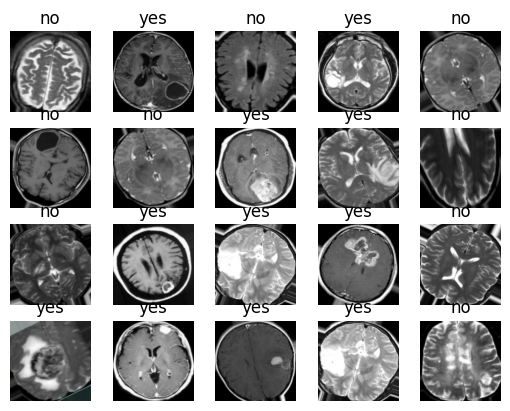

In [19]:
class_names = aug_df.class_names
class_names
for images, labels in aug_df.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# **Data Splitting**

In [20]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = (240, 240)

    for directory in dir_list:
        for filename in listdir(directory):
            file_path = os.path.join(directory, filename)
            image = cv2.imread(file_path)
            # normalize values
            image = image / 255.
            # convert image to numpy array
            X.append(image)
            if 'yes' in directory:
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    print(f'Total Images: {len(X)}')
    print(f'X shape : {X.shape}')
    print(f'y shape : {y.shape}')

    return X, y

X, y = load_data([augmented_yes_dir, augmented_no_dir], (240, 240))

Total Images: 1827
X shape : (1827, 224, 224, 3)
y shape : (1827, 1)


In [21]:
from sklearn.model_selection import train_test_split
seed_value = 100

# First split: Split into training and test+validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=seed_value,
    stratify=y  # Ensure the split preserves class distribution
)

# Second split: Split test+validation into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, 
    test_size=0.3,  # This represents 0.3 of the 0.3 of the original dataset
    random_state=seed_value,
    stratify=y_test_val  # Ensure the split preserves class distribution
)

print("Train class distribution:")
print(np.bincount(y_train.flatten()))
print("Validation class distribution:")
print(np.bincount(y_val.flatten()))
print("Test class distribution:")
print(np.bincount(y_test.flatten()))

Train class distribution:
[658 620]
Validation class distribution:
[85 80]
Test class distribution:
[197 187]


# **Call Backs**

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3
)

# **Model 1**

In [93]:
target_size = (224, 224)
model = tf.keras.models.Sequential([
    # Resize images to target size
    tf.keras.layers.Resizing(target_size[0], target_size[1]),

    # Normalize pixel values to [0, 1]
    tf.keras.layers.Lambda(lambda x: x / 255.0),

    # Convolutional layers
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),


    # Flatten and Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[reduce_lr])

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.5078 - loss: 0.7065 - val_accuracy: 0.5152 - val_loss: 0.7074 - learning_rate: 0.0010
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5227 - loss: 0.6939 - val_accuracy: 0.5152 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5646 - loss: 0.6658 - val_accuracy: 0.5697 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5823 - loss: 0.6422 - val_accuracy: 0.5091 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6283 - loss: 0.6219 - val_accuracy: 0.5212 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5854 - loss: 0.6241 - val_accuracy: 0.5636 - val_loss: 0.6802 - learning_rate: 0.0010
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6044 - loss: 0.5984 - val_a

In [94]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8830 - loss: 0.3880
Test accuracy: 0.8490


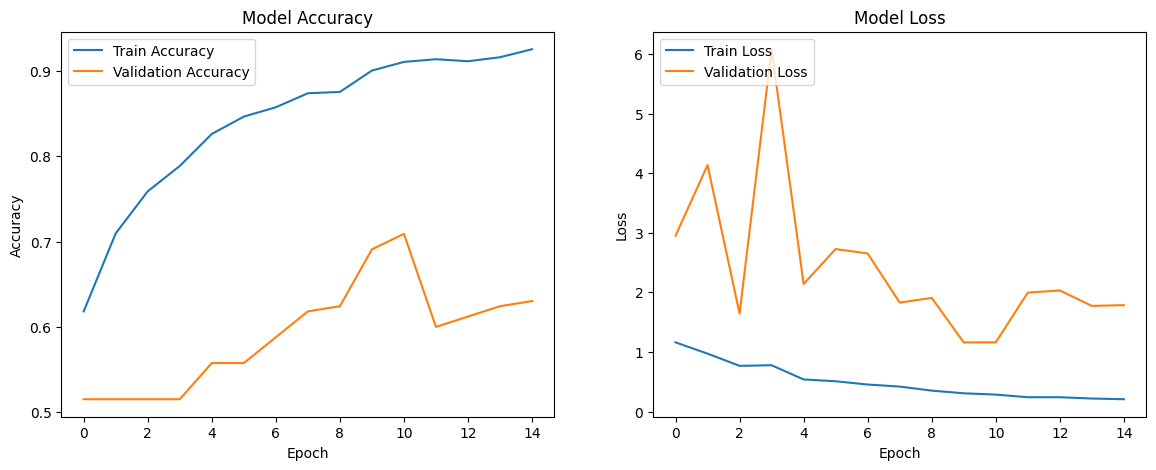

In [85]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84       197
           1       0.81      0.91      0.85       187

    accuracy                           0.85       384
   macro avg       0.85      0.85      0.85       384
weighted avg       0.85      0.85      0.85       384

Confusion Matrix:
[[156  41]
 [ 17 170]]


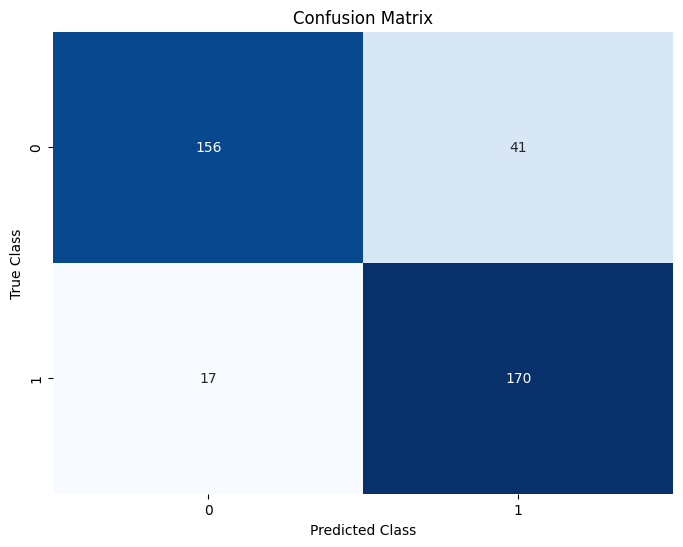

In [95]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes

# True labels
y_true = y_test.flatten()  # Flatten to match the shape of y_pred_classes

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# **Model 2**

In [35]:
from tensorflow.keras.applications import VGG16
# load base model
target_size = (224, 224, 3)
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=target_size
)

In [36]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

NUM_CLASSES = 1

model_2 = Sequential()
model_2.add(base_model)
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model_2.layers[0].trainable = False

model_2.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

In [37]:
history_2 = model_2.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[reduce_lr])

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.5500 - loss: 0.7341 - val_accuracy: 0.6788 - val_loss: 0.6063 - learning_rate: 1.0000e-04
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.6450 - loss: 0.6424 - val_accuracy: 0.7030 - val_loss: 0.5653 - learning_rate: 1.0000e-04
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.6873 - loss: 0.5801 - val_accuracy: 0.7152 - val_loss: 0.5176 - learning_rate: 1.0000e-04
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.7638 - loss: 0.4916 - val_accuracy: 0.7818 - val_loss: 0.4838 - learning_rate: 1.0000e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.7831 - loss: 0.4654 - val_accuracy: 0.8000 - val_loss: 0.4575 - learning_rate: 1.0000e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8136 - loss: 0.4402 - val_accuracy: 0.8000 - val_loss: 0.4402 - learning_rate: 1.0000e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy:

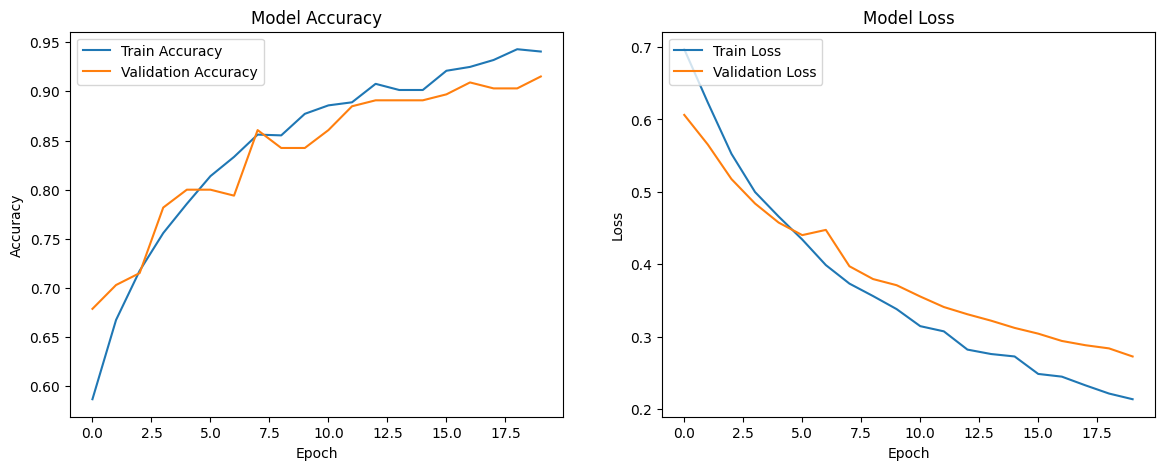

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       197
           1       0.93      0.93      0.93       187

    accuracy                           0.93       384
   macro avg       0.93      0.93      0.93       384
weighted avg       0.93      0.93      0.93       384

Confusion Matrix:
[[184  13]
 [ 14 173]]


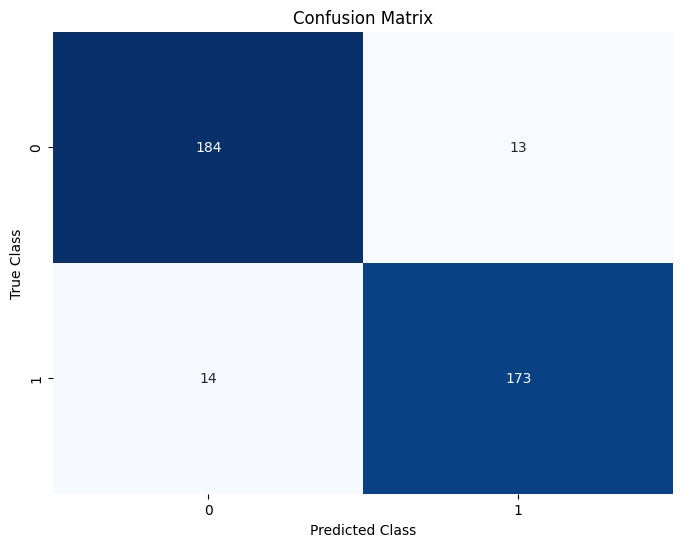

In [39]:
# Make predictions
y_pred = model_2.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary classes

# True labels
y_true = y_test.flatten()  # Flatten to match the shape of y_pred_classes

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [40]:
model_2.save('brain_mri_detection_model.h5')

In [96]:
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageFilter, ImageOps
import numpy as np

def preprocess_image(img_path):
    # Load the image
    img = Image.open(img_path).convert('RGB')
    # Convert to grayscale
    gray_img = img.convert('L')
    
    # Apply Gaussian blur
    gray_img = gray_img.filter(ImageFilter.GaussianBlur(5))
    
    # Apply binary threshold
    threshold = 45
    gray_img = gray_img.point(lambda p: p > threshold and 255)
    
    # Find the bounding box of the brain region (contour)
    bbox = gray_img.getbbox()
    if bbox:
        # Crop the image to the bounding box
        cropped_img = img.crop(bbox)
    else:
        # If no contours are found, use the original image
        cropped_img = img
    
    # Resize the image to the target size (224, 224)
    resized_img = cropped_img.resize((224, 224))
    
    # Convert the image to array and normalize
    img_array = image.img_to_array(resized_img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image to match the preprocessing during training
    
    return img_array

# Example usage
img_path = '/kaggle/input/brainmri-data/brain_tumor_dataset/no/26 no.jpg'

# Preprocess the image
processed_img = preprocess_image(img_path)

# Make the prediction
prediction = model.predict(processed_img)
prediction_2 = model_2.predict(processed_img)

# Interpret the prediction
result = "Tumor Detected" if prediction[0] > 0.5 else "No Tumor Detected"
print(prediction)
print(result)

result_2 = "Tumor Detected" if prediction_2[0] > 0.5 else "No Tumor Detected"
print(prediction_2)
print(result_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.1919843]]
No Tumor Detected
[[0.10146505]]
No Tumor Detected
